<a href="https://colab.research.google.com/github/KatrouA/Prediction-of-Product-Sales/blob/main/project_1_part5_asmak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports and read data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
fpath = "/content/drive/MyDrive/CodingDojo/02-IntroML/Week06/Data/sales_predictions_2023.csv"
df = pd.read_csv(fpath)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### Explore the Data

In [ ]:
df.duplicated().sum()

0

In [ ]:
# Identify if a value is null or not
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Feautures Inspection

---

In [ ]:
df['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [ ]:
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [ ]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF':"Low Fat",'low fat':'Low Fat', 'reg':'Regular' })
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [ ]:
df['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [ ]:
df['Item_MRP'].value_counts()

172.0422    7
170.5422    6
196.5084    6
188.1872    6
142.0154    6
           ..
97.3384     1
83.1934     1
96.6752     1
152.6682    1
75.4670     1
Name: Item_MRP, Length: 5938, dtype: int64

In [ ]:
df['Outlet_Identifier'].value_counts()

OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

In [ ]:
df['Outlet_Establishment_Year'].value_counts()

1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64

In [ ]:
df['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [ ]:
df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [ ]:
df['Item_Outlet_Sales'].value_counts()

958.7520     17
1342.2528    16
703.0848     15
1845.5976    15
1278.3360    14
             ..
4124.6310     1
6622.7126     1
1614.5650     1
5602.7070     1
2778.3834     1
Name: Item_Outlet_Sales, Length: 3493, dtype: int64

### Train and split Data

In [ ]:
# The target we are trying to predict
y = df['Item_Outlet_Sales']
# The features we will use to make the prediction
X = df.drop(columns = 'Item_Outlet_Sales')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Missing values:

### Item_Weight

In [ ]:
# Define the list of features for this strategy
num_cols = ['Item_Weight']
# Instantiate the imputer object from the SimpleImputer class with strategy 'median'
impute_median = SimpleImputer(strategy='median')
# Fit the imputer object on the numeric training data with .fit()
impute_median.fit(X_train[num_cols])
# Transform the training data
X_train_num_imputed = impute_median.transform(X_train[num_cols])
# Transfrom the testing data
X_test_num_imputed = impute_median.transform(X_test[num_cols])

# Check the imputation
X_train_num_imputed.isna().sum()

Item_Weight    0
dtype: int64

In [ ]:
X_train.isna().sum()

Item_Identifier                 0
Item_Weight                  1107
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1812
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

### Testing another methode to more practice

In [ ]:
def explore_numeric(X_train, x, figsize=(6,5) ):
  # Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=X_train, x=x, ax=axes[0])
  # Boxplot on Bottom
  sns.boxplot(data=X_train, x=x, ax=axes[1])
  ## Adding a title
  axes[0].set_title(f"Column: {x}")
  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()
  ## Print message with info on the count and % of null values
  null_count = X_train[x].isna().sum()
  null_perc = null_count/len(X_train)* 100
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")

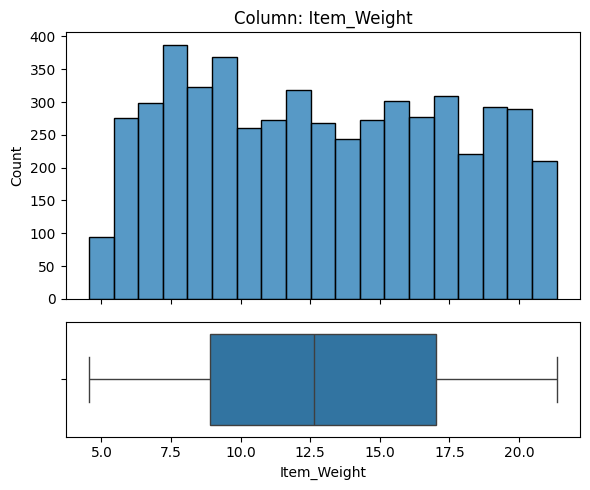

- NaN's Found: 1107 (17.32%)


In [ ]:
# Confirming the dtype to select correct EDA function
feature = "Item_Weight"
X_train[feature].dtype
explore_numeric (X_train, feature)

In order to know how to handle them, I should try to determine if they are missing at random or if there is meaning in the fact that they are missing.

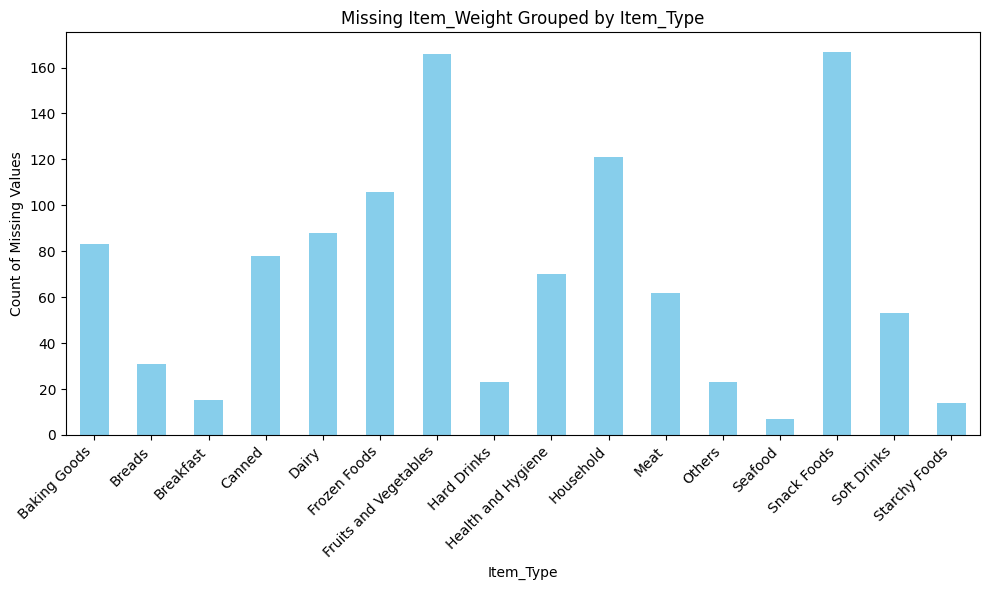

In [ ]:
# Group missing values of Item_Weight by the value types of Item_Type
missing_grouped = X_train[X_train['Item_Weight'].isna()].groupby('Item_Type').size()

# Plot the counts of missing Item_Weight values grouped by Item_Type value types
plt.figure(figsize=(10, 6))
missing_grouped.plot(kind='bar', color='skyblue')
plt.title('Missing Item_Weight Grouped by Item_Type')
plt.xlabel('Item_Type')
plt.ylabel('Count of Missing Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

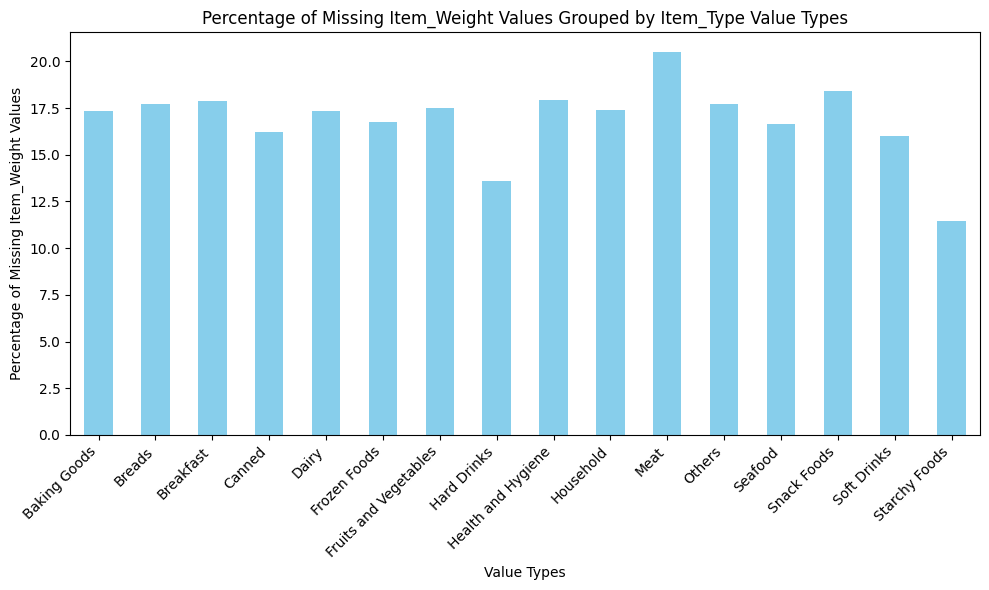

In [ ]:
# Trying with the percentage values
# Calculate total count of values in each group
total_count_grouped = X_train.groupby('Item_Type').size()

# Calculate percentage of missing values in each group
missing_percentage = (missing_grouped / total_count_grouped) * 100

# Plot the percentages of missing values grouped by value types
plt.figure(figsize=(10, 6))
missing_percentage.plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Item_Weight Values Grouped by Item_Type Value Types')
plt.xlabel('Value Types')
plt.ylabel('Percentage of Missing Item_Weight Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Mode imputation within each food type
X_train['Item_Weight'] = X_train.groupby('Item_Type')['Item_Weight'].transform(lambda x: x.fillna(x.mode().iloc[0]))

# Check if there are any remaining missing values
remaining_missing = X_train[X_train['Item_Weight'].isna()]

# Print remaining missing values (if any)
print(remaining_missing)

Empty DataFrame
Columns: [Item_Identifier, Item_Weight, Item_Fat_Content, Item_Visibility, Item_Type, Item_MRP, Outlet_Identifier, Outlet_Establishment_Year, Outlet_Size, Outlet_Location_Type, Outlet_Type]
Index: []


In [ ]:
X_train.isna().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1812
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [ ]:
X_test.isna().sum()

Item_Identifier                0
Item_Weight                  356
Item_Fat_Content               0
Item_Visibility                0
Item_Type                      0
Item_MRP                       0
Outlet_Identifier              0
Outlet_Establishment_Year      0
Outlet_Size                  598
Outlet_Location_Type           0
Outlet_Type                    0
dtype: int64

### Outlet_Size

In [ ]:
# ordinal_cols
ordinal_cols = ['Outlet_Size']
ordinal_cols

['Outlet_Size']

In [ ]:
# Fit the simple imputer on the features in ordinal_cols
impute_ordinal = SimpleImputer(strategy='most_frequent')
impute_ordinal.fit(X_train[ordinal_cols])

SimpleImputer(strategy='most_frequent')

In [ ]:
# Transform the training data's ordinal_cols
X_train_ord_imputed = impute_ordinal.transform(X_train[ordinal_cols])
X_test_ord_imputed = impute_ordinal.transform(X_test[ordinal_cols])
# Check the imputation
X_train_ord_imputed.isna().sum()

Outlet_Size    0
dtype: int64